In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scienceplots
import warnings
warnings.filterwarnings("ignore")
plt.style.use('science')

In [43]:
models = {
    'harderLASSO ANN': {'color': 'black', 'marker': 'o', 'linestyle': 'solid', 'lw': 2,  'id': 0},
    'LASSO ANN': {'color': 'black', 'marker': '', 'linestyle': 'solid', 'lw': 2,  'id': 1},

    'harderLASSO linear': {'color': 'blue', 'marker': 'o', 'linestyle': 'solid', 'lw': 2, 'id': None},
    'LASSO linear': {'color': 'blue', 'marker': '', 'linestyle': 'solid', 'lw': 2, 'id': None},

    'LassoNet': {'color': 'orange', 'marker': '', 'linestyle': 'solid', 'lw': 1, 'id': 2},
    'RF': {'color': 'magenta', 'marker': '', 'linestyle': 'solid', 'lw': 1, 'id': 3},
    'XGBoost': {'color': 'green', 'marker': '', 'linestyle': 'solid', 'lw': 1, 'id': 4}
}

In [44]:
def data_processing(file_name):
    df = pd.read_csv(file_name)

    def convert_line(line):
        if isinstance(line, str):
            line = line.replace('array', 'np.array')
            line = eval(line, {"np": np, "float32": np.float32})
        return line

    for column in df.drop('run_id', axis='columns').columns:
        df[column] = df[column].apply(convert_line)

    df.rename(columns={
        'AnnLassoRegressorl0': 'harderLASSO ANN',
        'AnnLassoClassifierl0': 'harderLASSO ANN',

        'AnnLassoRegressorl1': 'LASSO ANN',
        'AnnLassoClassifierl1': 'LASSO ANN',

        'LinearModell0':'harderLASSO linear',
        'LinearModell1': 'LASSO linear',

        'RandomForestRegressor': 'RF',
        'RandomForestClassifier': 'RF',

        'XGBoostRegressor': 'XGBoost',
        'XGBoostClassifier': 'XGBoost',

        'LNRegressor': 'LassoNet',
        'LNClassifier': 'LassoNet',

        'LogisticRegressionCV': 'LR'}, inplace=True)

    return df


def perf_measure(S_hat, S):
    """
    Evaluates based on different metrics how close a prediction is to a true set of indices.

    Args:
        S_hat (array): selected features indices.
        S (array): true valuable features indices.

    Returns:
        ESR : Exact support recorvery (If S_hat == S or not)
        F1 score :
        TPR : True positive rate
        FDR : False discovery rate

    """
    S_hat = set(S_hat)
    S = set(S)
    if S_hat==S:
        return True, 1, 1, 0

    TP = len(S_hat & S)  # True Positives
    FP = len(S_hat - S)  # False Positives
    FN = len(S - S_hat)  # False Negatives
    F1 = TP/(TP+0.5*(FN+FP))

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FDR = FP / (FP + TP) if (FP + TP) > 0 else 0

    return False, F1, TPR, FDR

def test_mse(mu_hat_x, mu_x):
    mse = (np.square(mu_hat_x - mu_x)).mean(axis=0)
    return np.sqrt(mse)

def PAS(accuracy_test, k, p):
    """
    Computes the penalized accuracy score if a model on a particular set.

    Args:
        accuracy_test (float): accuracy on test set
        k (int): number of selected features
        p (int): total number available features

    Returns:
        float: a penalized testing accuracy.
    """
    return accuracy_test * (1-k/p)

def compute_simulation_metrics_for_s(s, simu_name, models = models):
    """
    Compute simulation metrics for a given simulation setting and return the average metrics for each model.

    Args:
        s (int): The value of `s` which defines the number of important features.
        simu_name (str): The name of the simulation, used to locate the corresponding result and data files.

    Returns:
        dict: A dictionary where each key is a model name, and the value is another dictionary containing
              the average values of the following metrics:
              - '|S^|': The average number of selected features.
              - 'PESR': The Proportion of Error Set Rate.
              - 'f1': The F1 score.
              - 'TPR': The True Positive Rate.
              - 'FDR': The False Discovery Rate.
              - 'test error': The average test error (Mean Squared Error).
    """
    data_dict = {}
    results_root = os.path.join(simu_name, 'results')
    df_basic_models = data_processing(f"{results_root}/basic_models/s{s}.csv")
    df_AnnLasso_models = data_processing(f"{results_root}/AnnLasso_models/s{s}.csv")
    df_results = pd.merge(df_basic_models, df_AnnLasso_models, on='run_id', how='inner').reindex(columns=['run_id'] + list(models.keys()))

    data_file_path = os.path.join(simu_name, f'data/')
    true_features_path = os.path.join(data_file_path, f'features_{s}.csv')
    true_features_df = pd.read_csv(true_features_path)

    for run_id in df_results['run_id']:
        true_features = true_features_df.iloc[:, run_id]
        df_run_id = df_results[df_results['run_id'] == run_id].iloc[0]
        for model in models:
            ### Features selection analysis ###
            selected_features = df_run_id[model][0]
            n_feat = len(selected_features)
            PESR, f1, TPR, FDR = perf_measure(selected_features, true_features)
            metrics = {'|S^|': n_feat, 'PESR': PESR, 'f1': f1, 'TPR': TPR, 'FDR': FDR, 'test error' : None}
            data_dict.setdefault(model, {metric : [] for metric in metrics})
            for metric in list(metrics.keys())[:-1]:
                data_dict[model][metric].append(metrics[metric])

            ### Predictive error analysis ###
            data_dict[model]['test error'].append(np.sqrt(df_run_id[model][1]))

    for model in models:
        data_dict[model] = {metric: np.mean(data_dict[model][metric]) for metric in metrics}

    return data_dict


def compute_simulation_metrics(simu_name, models=models):
    results = {}
    s_values = range(31) if simu_name == 'linear' else range(0, 21, 2)

    for s in s_values:
        results[s] = compute_simulation_metrics_for_s(s, simu_name, models)
    return results

In [45]:
def plot_simulation_metrics(results, models, s_range, exclude_models=[], x_ticks=None, figsize=(20, 6), dpi=300, save_path=None):
    """
    Plots the simulation metrics (PESR, F1, MSE test) for different models.

    Parameters:
        results (dict): Dictionnary containing the simulation results.
        models (dict): Dictionary mapping model names to their colors and styles.
        s_range (list): List of evaluated s values.
        exclude_models (list): List of model names to exclude from the plot. Defaults to None.
        x_ticks (list): List of desired x ticks on plot.
        figsize (tuple): Figure size for the plot. Default is (12, 12).
        dpi (int): DPI for the plot. Default is 300.
        save_path (str): Path to save the plot. If None, it shows the plot.
    """
    x_ticks = s_range if x_ticks is None else x_ticks
    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
    metric_names = ['PESR', 'f1', 'test error']

    for model, style in models.items():
        if model in exclude_models:
            continue
        for ax, metric in zip(axes, metric_names):
            metric_values = [results[s][model][metric] for s in s_range]
            ax.plot(s_range, metric_values, label=model, color=style['color'],
                    marker=style['marker'], linestyle=style['linestyle'], lw=style['lw'], markersize=5)

    # Set axis labels and legends
    for ax, name in zip(axes, ['PESR', r'$F_1$', 'test error']):
        ax.set_xlabel('s')
        ax.set_ylabel(name)
        ax.set_xticks(x_ticks)
        ax.minorticks_off()

    plt.tight_layout()
    axes[2].legend(ncols=3)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# Linear Regression

### Phase transition: linear 
n=70, p=250 and snr=3, 100 simulations

In [46]:
linear_results = compute_simulation_metrics('linear')

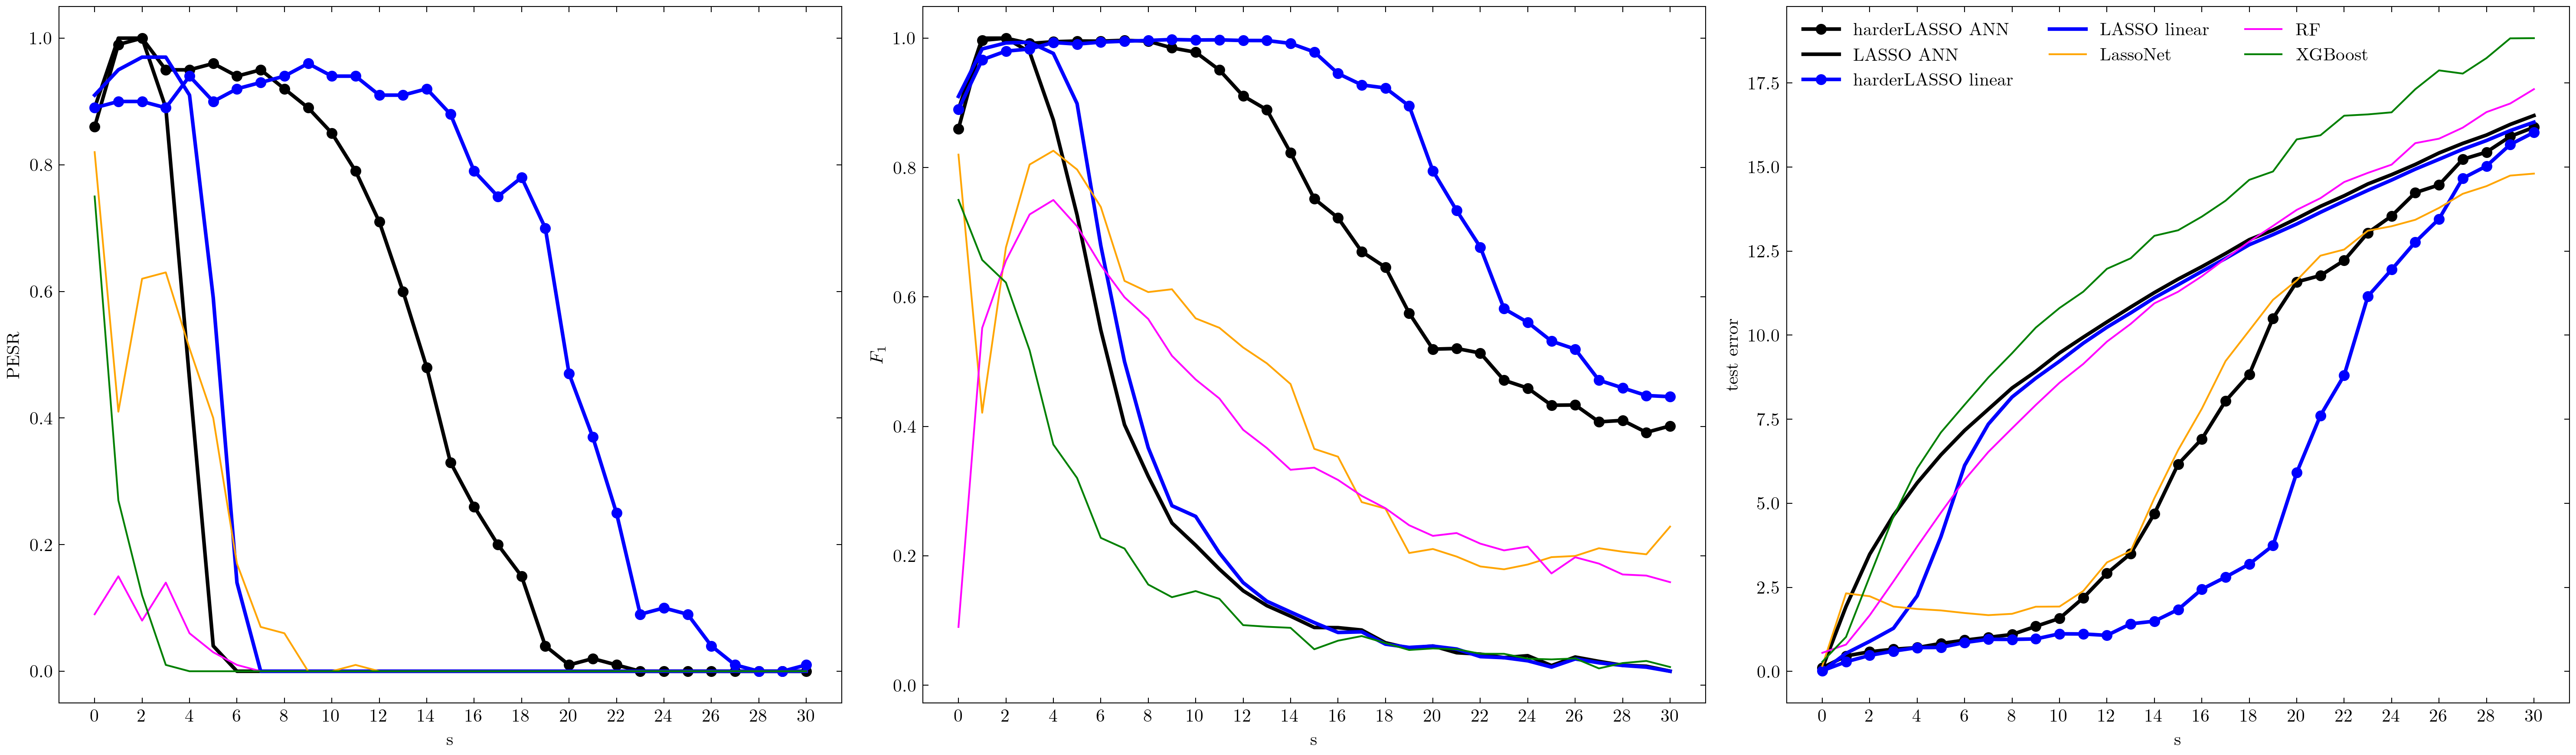

In [47]:
plot_simulation_metrics(linear_results, models, s_range=range(31), x_ticks=range(0,31,2), save_path='linear/results/linearsimuresults.pdf')

# Non linear regression

### Phase transition: non linear
n=500, p=50, SNR=10 and 100 simulations

In [48]:
nonlinear_results = compute_simulation_metrics('nonlinear')

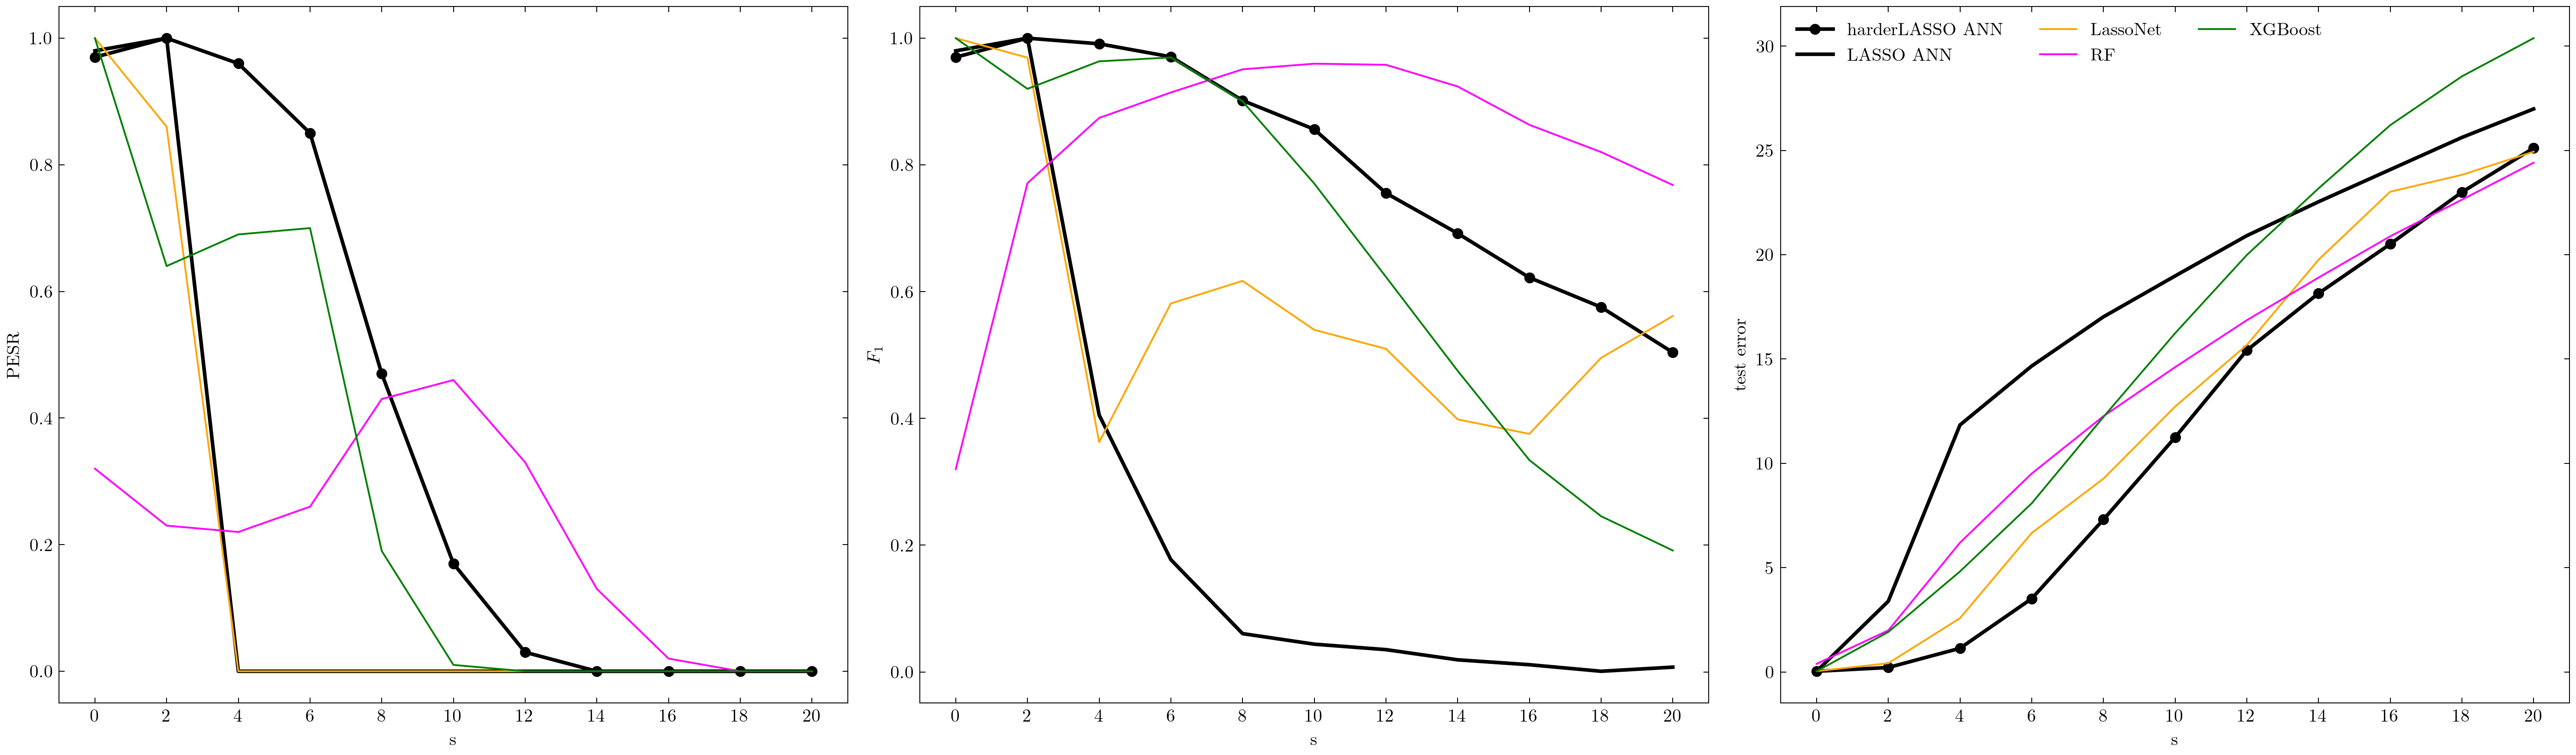

In [49]:
plot_simulation_metrics(nonlinear_results, models, range(0, 21, 2), exclude_models=['LASSO linear', 'harderLASSO linear'], save_path='nonlinear/results/nonlinearsimuresults.pdf')

# Classification

In [50]:
list(models.keys())

['harderLASSO ANN',
 'LASSO ANN',
 'harderLASSO linear',
 'LASSO linear',
 'LassoNet',
 'RF',
 'XGBoost']

In [51]:
from pathlib import Path

results, p_values = {}, {}

dataset_folders = ['biological_datasets', 'classical_datasets', 'other_datasets']
for dataset_folder in dataset_folders:
    dataset_path = Path(os.path.join("classification", dataset_folder))
    for subfolder in dataset_path.iterdir():
        if subfolder.is_dir():
            if 'dermatology' not in subfolder.name and 'digits' not in subfolder.name:
                p = pd.read_csv(os.path.join(subfolder, 'data.csv')).shape[1]
                p_values[subfolder.name] = p

                df_basic_models = data_processing(os.path.join(subfolder, 'results/basic_models/results.csv')).drop(columns='baseline error')
                df_AnnLasso_models = data_processing(os.path.join(subfolder, 'results/AnnLasso_models/results.csv')).drop(columns='baseline error')
                df_linear_model = data_processing(os.path.join(subfolder, 'results/linear_model/results.csv')).drop(columns='baseline error')

                df_temp = pd.merge(df_basic_models, df_AnnLasso_models, on='run_id')
                df_results = pd.merge(df_temp, df_linear_model, on='run_id').reindex(columns=['run_id'] + [model for model in models.keys() if 'linear' not in model] + ['LR'])
                results[subfolder.name] = {model: (
                    np.mean([len(i[0]) for i in df_results[model]]),
                    round(np.mean([i[1] for i in df_results[model]]), 2)
                ) for model in df_results.drop(["run_id"], axis='columns').columns}

# Create and fill the DataFrame with results
results_class = pd.DataFrame.from_dict(results, orient='index')
results_class.index.name = "Dataset"

results_class

,harderLASSO ANN,LASSO ANN,LassoNet,RF,XGBoost,LR
Dataset,,,,,,
obesity,"(3.0, 0.89)","(5.86, 0.62)","(15.68, 0.81)","(11.98, 0.95)","(12.28, 0.97)","(16.0, 0.93)"
dry bean,"(6.0, 0.91)","(7.0, 0.9)","(15.98, 0.92)","(16.0, 0.92)","(13.0, 0.93)","(15.92, 0.93)"
aids,"(3.76, 0.88)","(3.92, 0.82)","(18.82, 0.86)","(5.12, 0.85)","(6.42, 0.88)","(21.4, 0.86)"
dna,"(9.0, 0.91)","(12.26, 0.9)","(148.44, 0.94)","(83.06, 0.96)","(18.64, 0.95)","(87.3, 0.96)"
iris,"(1.78, 0.95)","(1.96, 0.8)","(3.1, 0.93)","(4.0, 0.95)","(2.04, 0.95)","(3.8, 0.96)"
breast,"(2.12, 0.94)","(4.22, 0.95)","(25.88, 0.96)","(22.9, 0.96)","(9.68, 0.96)","(16.64, 0.97)"
wine,"(2.16, 0.9)","(4.96, 0.94)","(10.72, 0.97)","(13.0, 0.98)","(7.02, 0.96)","(10.82, 0.98)"
USPS,"(13.88, 0.83)","(51.24, 0.81)","(255.26, 0.93)","(208.82, 0.96)","(108.62, 0.96)","(241.24, 0.94)"
mail,"(14.3, 0.89)","(25.32, 0.88)","(56.5, 0.94)","(19.66, 0.95)","(23.24, 0.95)","(56.16, 0.93)"


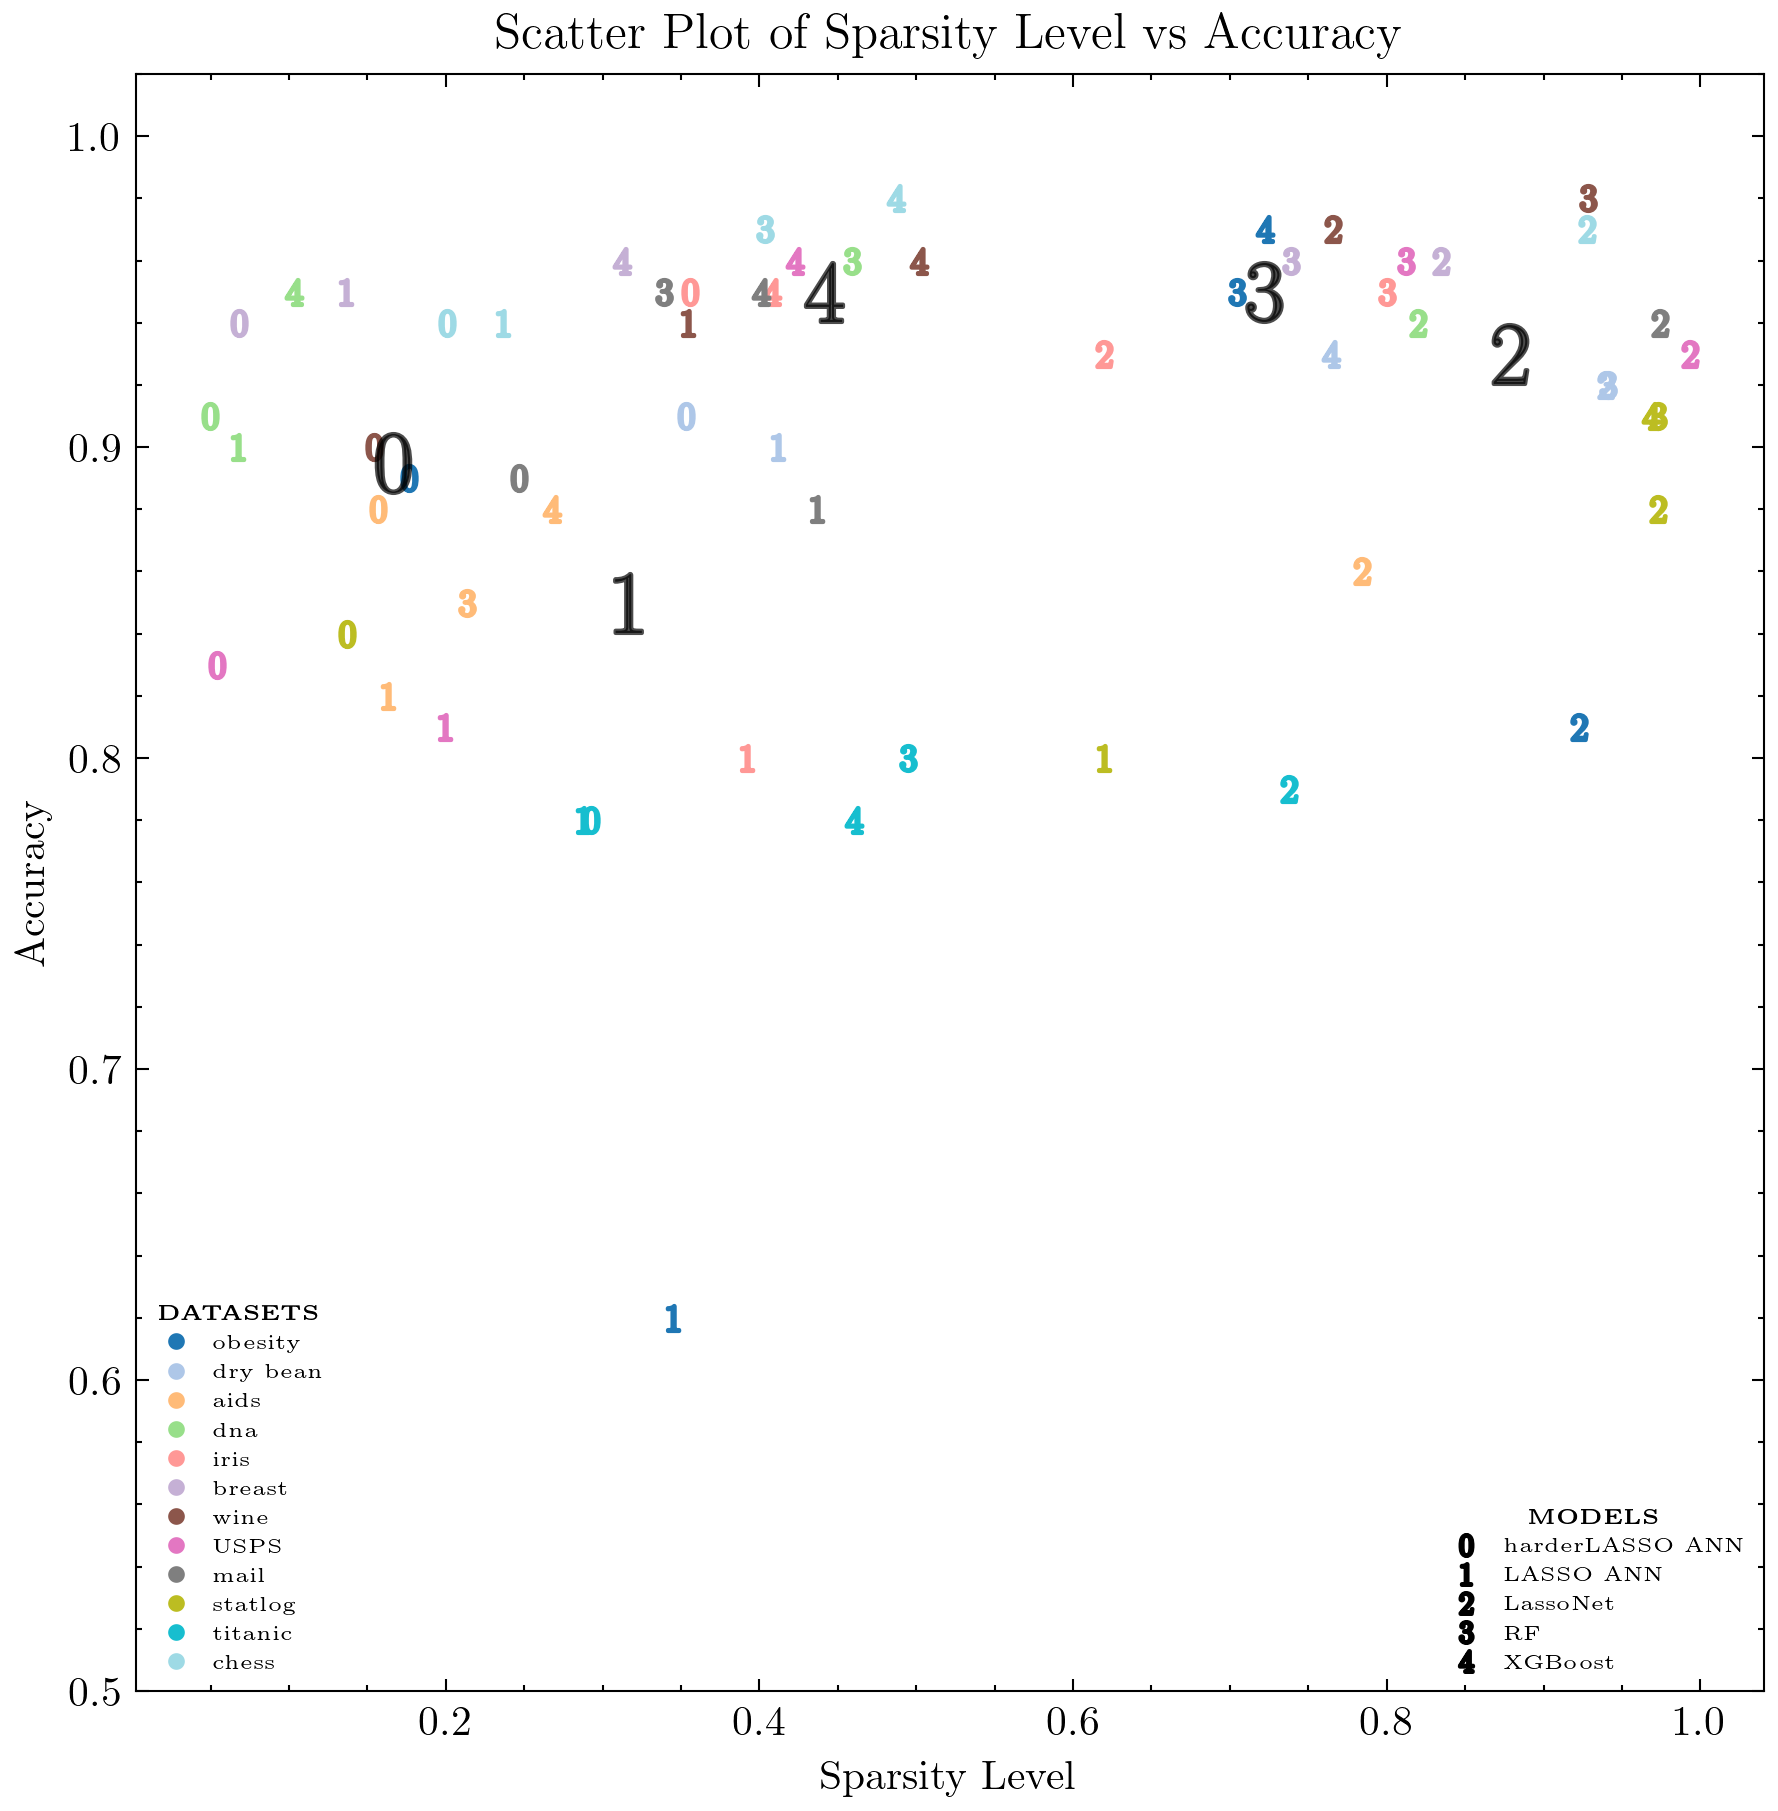

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.lines import Line2D

plt.figure(figsize=(7, 7), dpi=300)
plotted_models = results_class.drop(columns='LR').columns
total_values = {}
datasets = results_class.index
datasets_colors = {dataset: color for dataset, color in zip(datasets, cm.get_cmap('tab20', len(datasets)).colors)}
plotted_datasets = set()

# Plot the data points
for model in plotted_models:
    total_values = []
    model_results = results_class[model]
    for dataset in datasets:
        sparsity_level = model_results[dataset][0]/p_values[dataset]
        accuracy = model_results[dataset][1]

        label = dataset if dataset not in plotted_datasets else None
        plt.scatter(sparsity_level, accuracy, c=[datasets_colors[dataset]],
                    marker="$" + str(models[model]['id']) + "$", label=label)
        total_values.append((sparsity_level, accuracy))
        plotted_datasets.add(dataset)

    a, b = (np.median([i[0] for i in total_values]), np.median([i[1] for i in total_values]))
    plt.scatter(a, b, c='black', marker="$" + str(models[model]['id']) + "$", s=200, alpha=0.7)

# Create the datasets legend
datasets_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=datasets_colors[dataset], markersize=5, label=dataset)
                   for dataset in datasets if dataset in plotted_datasets]
legend_datasets = plt.legend(handles=datasets_legend, title=r"\bf{DATASETS}", loc="lower left", fontsize=5, title_fontsize=5)

# Create the models legend
models_legend = [Line2D([0], [0], marker="$" + str(models[model]['id']) + "$", color='black', linestyle='None', markersize=5, label=model) for model in plotted_models]
legend_models = plt.legend(handles=models_legend, title=r"\bf{MODELS}", loc="lower right", fontsize=5, title_fontsize=5)

# Add the datasets legend back to the plot
plt.gca().add_artist(legend_datasets)

# Labels, title, and saving
plt.ylim(0.5, 1.02)
plt.xlabel("Sparsity Level")
plt.ylabel("Accuracy")
plt.title("Scatter Plot of Sparsity Level vs Accuracy")
plt.savefig("classification/classificationsimuresults.pdf")
plt.show()

### Features selected

In [53]:
import itertools

features = {}

dataset_folders = ['biological_datasets', 'other_datasets', 'classical_datasets']
for dataset_folder in dataset_folders:
    dataset_path = Path(os.path.join("classification", dataset_folder))
    for subfolder in dataset_path.iterdir():
        if 'wine' in subfolder.name or 'breast' in subfolder.name or 'titanic' in subfolder.name:
            if subfolder.is_dir():
                df = pd.read_csv(os.path.join(subfolder, 'data.csv')).drop("class", axis='columns')
                df_results = data_processing(os.path.join(subfolder, 'results/AnnLasso_models/results.csv'))["harderLASSO ANN"]

                feature_names = np.array(df.columns.tolist())
                selected_features = [feature_names[i[0]] for i in df_results.values]
                selected_features = list(itertools.chain(*selected_features))
                features[subfolder.name] = selected_features

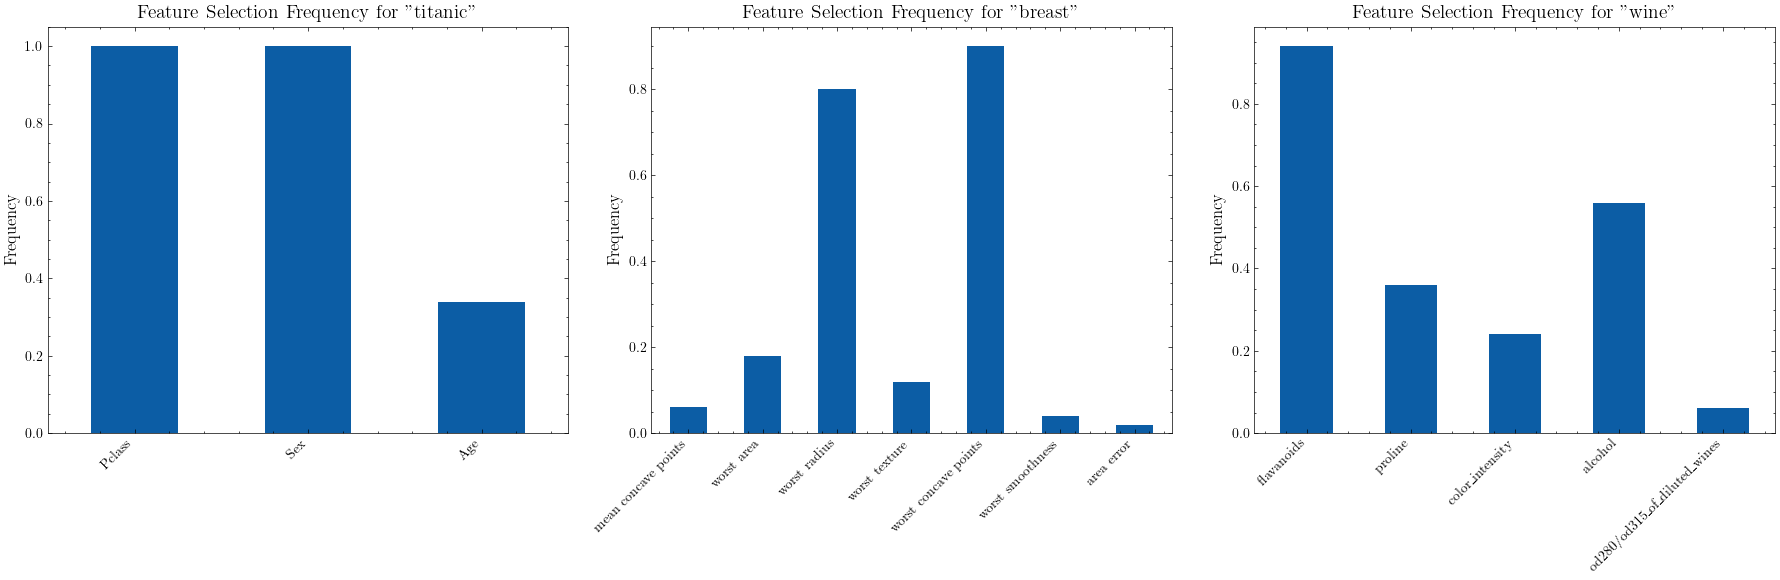

In [54]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Set up a figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust the figsize as needed

# Iterate through each dataset and its corresponding axis
for idx, (dataset, selected_features) in enumerate(features.items()):
    # Count the occurrences of each feature
    count = Counter(selected_features)

    # Create a DataFrame from the counts
    df = pd.DataFrame.from_dict(count, orient='index', columns=['Frequency'])

    # Divide the frequency by 50 to get percentage or normalized values
    df['Frequency'] = df['Frequency'] / 50

    # Create a bar plot for each dataset on its respective axis
    ax = df.plot(kind='bar', legend=False, ax=axes[idx])

    # Set the title to the dataset name
    ax.set_title(f'Feature Selection Frequency for "{dataset}"', fontsize=14)

    # Set the labels for x and y axes
    ax.set_ylabel('Frequency', fontsize=12)

    # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.savefig("classification/selected_features_frequency.pdf")
# Show all plots
plt.show()

# Layers analysis

In [55]:
import itertools
import sys
import os
sys.path.append(os.path.abspath('..'))
import models.regression as regmodels
import utils

n_values = np.arange(100, 5000, 100)
data_dict = {}

# Load the true features for each run_id
true_features_df = pd.read_csv("layers_analysis/data/features.csv")

for n in n_values:
    data_dict[n] = {}
    df_results = data_processing(f"layers_analysis/results/n{n}/results.csv")

    # Iterate over each run_id in the results DataFrame
    for run_id in df_results['run_id'].unique():
        # Extract the true features for this specific run_id
        true_features = true_features_df.iloc[:, run_id]
        df_run_id = df_results[df_results['run_id'] == run_id].iloc[0]

        # Iterate over each model in the DataFrame
        for model in df_results.columns.drop("run_id"):
            data_dict[n].setdefault(model, [])
            selected_features = df_run_id[model][0]
            test_error = np.sqrt(df_run_id[model][1])
            PESR, f1, TPR, FDR = perf_measure(selected_features, true_features)
            data_dict[n][model].append((PESR, test_error))

    # Average PESR and test error for each model
    for model in data_dict[n]:
        avg_PESR = np.mean([metrics[0] for metrics in data_dict[n][model]])
        avg_test_error = np.mean([metrics[1] for metrics in data_dict[n][model]])
        data_dict[n][model] = (avg_PESR, avg_test_error)

In [56]:
indexes = {"AnnLassoRegressorl0(20,)": [], "AnnLassoRegressorl0(20, 10)": [], "AnnLassoRegressorl0(20, 10, 5)": []}

for n in range(100, 5000, 100):
    df_results = data_processing(f"layers_analysis/results/n{n}/results.csv")

    for model in indexes.keys():
        model_indexes = []
        errors = [i[1] for i in df_results[model]]
        for run_id, error in enumerate(errors):
            m = regmodels.AnnLassoRegressorl0()
            m.load(f"layers_analysis/results/n{n}/{model}/run{run_id+1}.pth")

            a, b = utils.nonlinearity_index(m)
            max_indexes_per_layer = [max(sublist) if sublist else 0 for sublist in a]

            mean_adjacent_indexes = [
                (max_indexes_per_layer[i] + max_indexes_per_layer[i + 1]) / 2
                for i in range(len(max_indexes_per_layer) - 1)
            ]
            mean_adjacent_indexes.append(max_indexes_per_layer[-1]/2)
            model_indexes.append(mean_adjacent_indexes)
        indexes[model].append(model_indexes)

In [57]:
for model in indexes.keys():
    indexes[model] = np.median(indexes[model], axis=1)

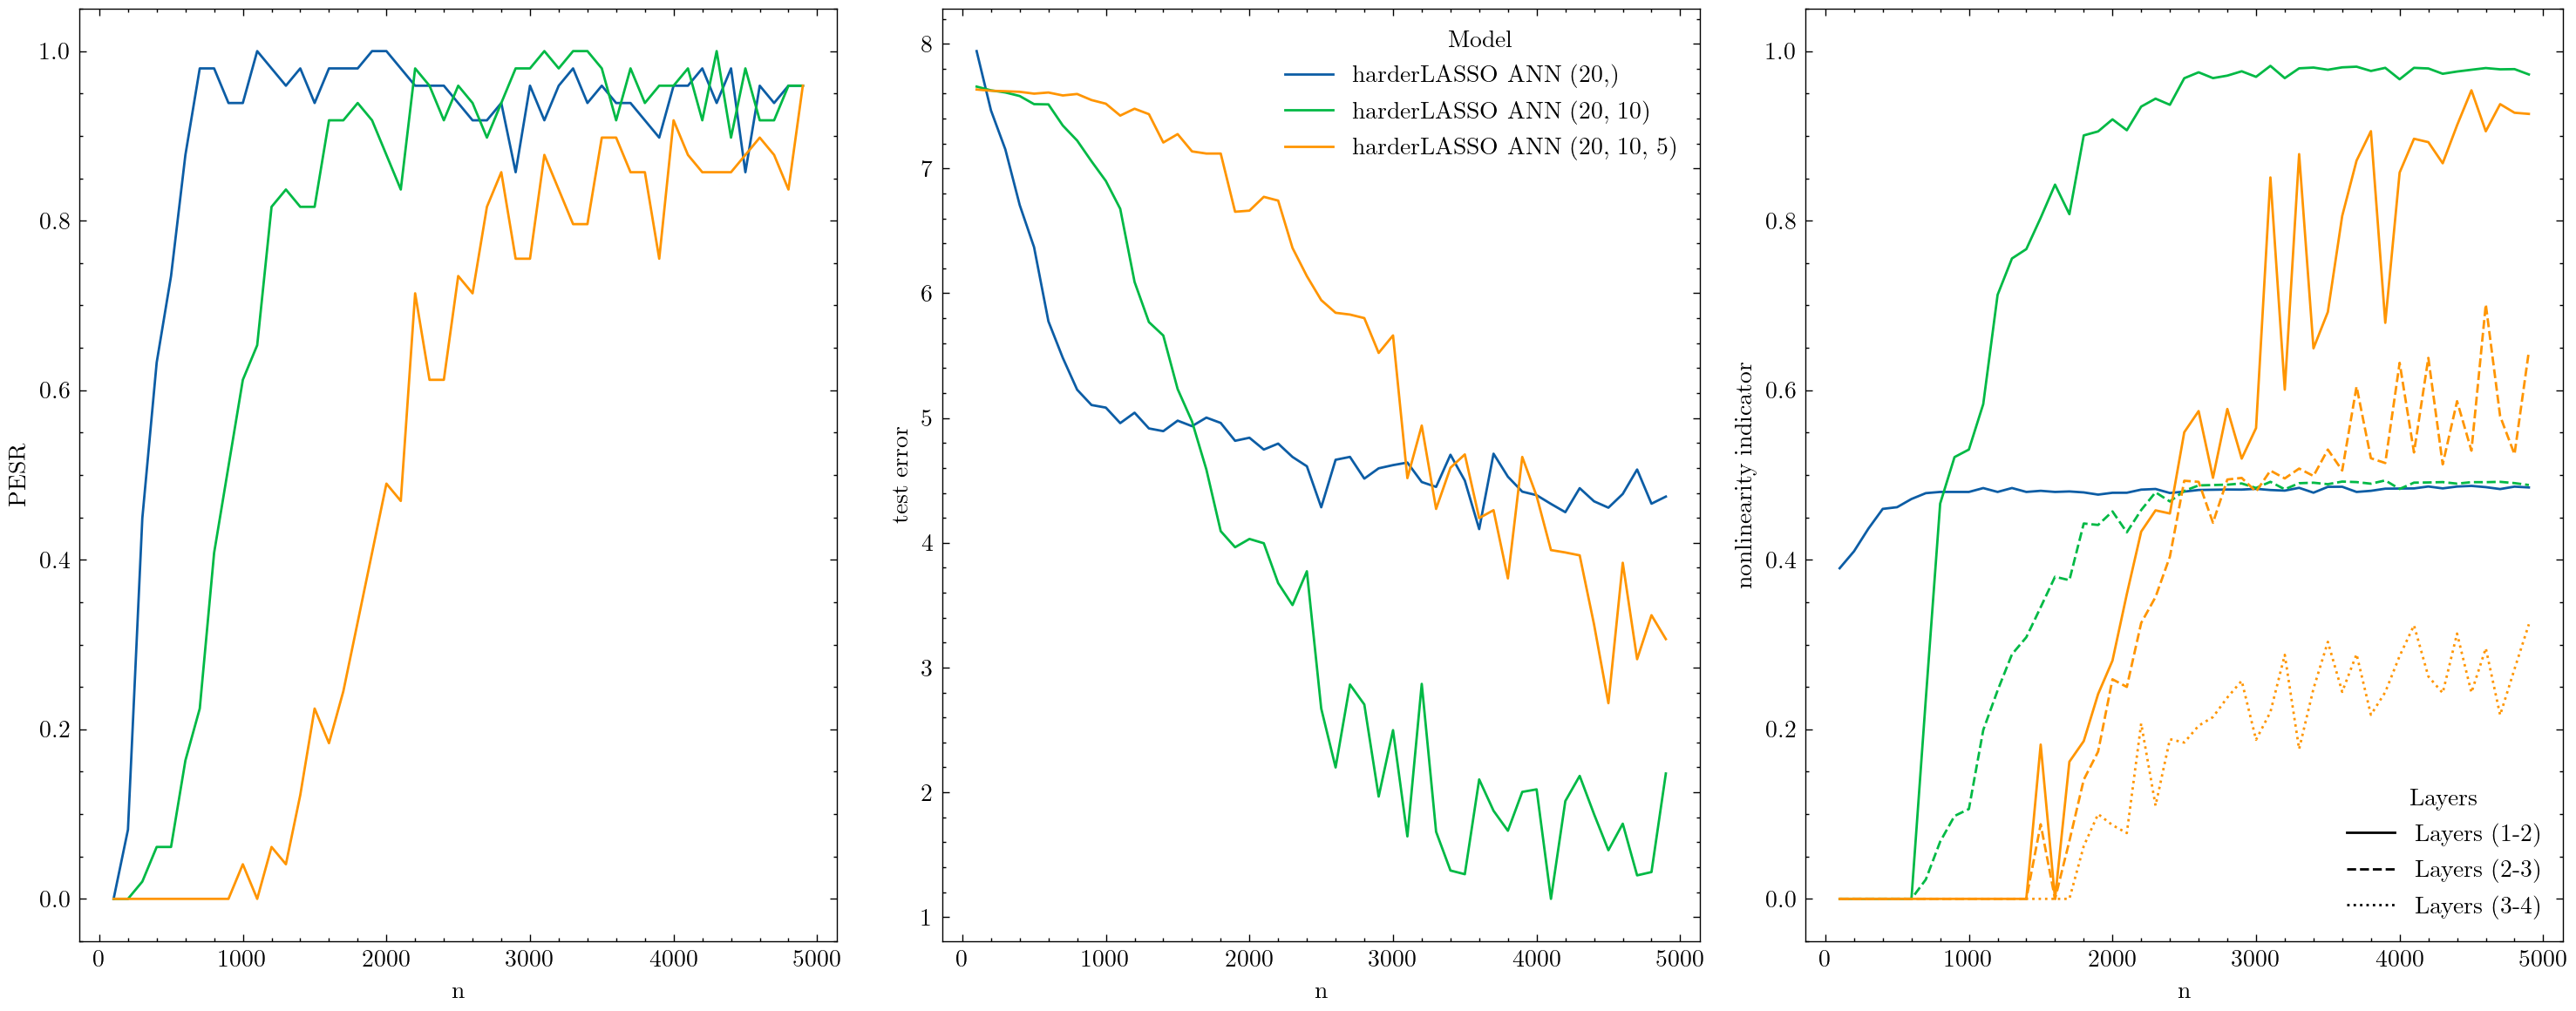

In [58]:
pesr_data = {n: {model: metrics[0] for model, metrics in models.items()} for n, models in data_dict.items()}
error_data = {n: {model: metrics[1] for model, metrics in models.items()} for n, models in data_dict.items()}

df_pesr = pd.DataFrame(pesr_data).T  # Transpose to have n values as rows and models as columns
df_error = pd.DataFrame(error_data).T

# Rename columns
df_error.rename(columns={
        'AnnLassoRegressorl0(20,)': 'harderLASSO ANN (20,)',
        'AnnLassoRegressorl0(20, 10)': 'harderLASSO ANN (20, 10)',
        'AnnLassoRegressorl0(20, 10, 5)': 'harderLASSO ANN (20, 10, 5)'},
        inplace=True
        )

fig, axs = plt.subplots(1, 3, figsize=(15, 6), dpi=200, sharex=True)

# Plot the mean PESR for each model
for model in df_pesr.columns:
    axs[0].plot(df_pesr.index, df_pesr[model], label=model)
axs[0].set_xlabel('n')
axs[0].set_ylabel('PESR')

# Plot the mean test error for each model
for model in df_error.columns:
    axs[1].plot(df_error.index, df_error[model], label=model)
axs[1].set_xlabel('n')
axs[1].set_ylabel('test error')
axs[1].legend(title='Model', fontsize=10)

# Plot the median values for the non-linearity index
line_styles = ['-', '--', ':']
layer_labels = [f"Layers ({i+1}-{i+2})" for i in range(len(line_styles))]
for model_idx, (model, median_indexes) in enumerate(indexes.items()):
    for layer_idx in range(median_indexes.shape[1]):
        axs[2].plot(
            n_values,
            median_indexes[:, layer_idx],
            label=model if layer_idx == 0 else None,
            color= f"C{model_idx}",
            linestyle=line_styles[layer_idx]
        )
layer_legend = [plt.Line2D([0], [0], color="black", linestyle=line_styles[i], label=layer_labels[i]) for i in range(len(layer_labels))]
axs[2].legend(handles=layer_legend, title="Layers", loc="lower right", fontsize=10)
axs[2].set_xlabel('n')
axs[2].set_ylabel('nonlinearity indicator')
axs[2].sharey(axs[0])

plt.tight_layout()
plt.savefig(f"layers_analysis/results/nonlinearityindexsimuresults.pdf")
plt.show()

In [59]:
import models.classification as classmodels
indexes = {}
dataset_folders = ['biological_datasets', 'other_datasets', 'classical_datasets']
for dataset_folder in dataset_folders:
    dataset_path = Path(os.path.join("classification", dataset_folder))
    for subfolder in dataset_path.iterdir():
        if subfolder.is_dir():
            model_indexes = []
            for run_id in range(50):
                m = classmodels.AnnLassoClassifierl0()
                m.load(f"{subfolder}/results/AnnLasso_models/AnnLassoClassifierl0_run{run_id}.pth")
                a, b = utils.nonlinearity_index(m)

                max_indexes_per_layer = [max(sublist) if sublist else 0 for sublist in a]

                mean_adjacent_indexes = [
                    (max_indexes_per_layer[i] + max_indexes_per_layer[i + 1]) / 2
                    for i in range(len(max_indexes_per_layer) - 1)
                ]
                mean_adjacent_indexes.append(max_indexes_per_layer[-1]/2)
                model_indexes.append(mean_adjacent_indexes)
            indexes[subfolder.name] = list(itertools.chain(*model_indexes))

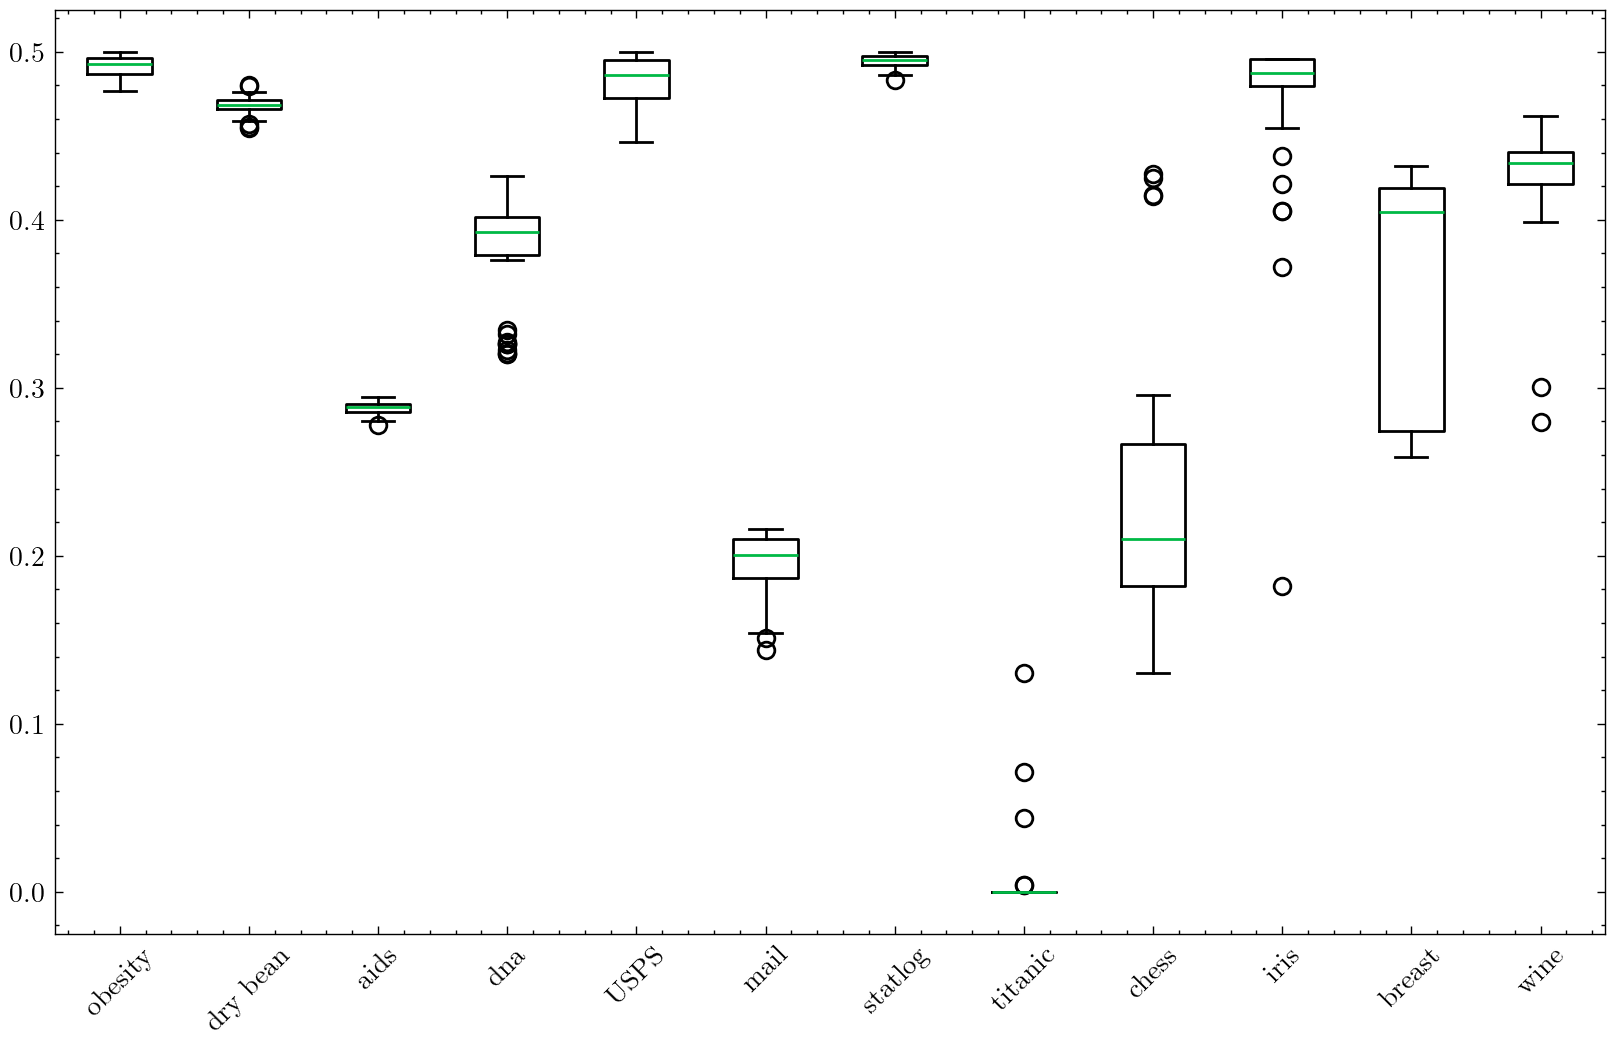

In [60]:
plt.figure(figsize=(10, 6), dpi=200)
plt.boxplot(indexes.values(), labels=indexes.keys())
plt.xticks(rotation=45)
plt.show()